In [1]:
# Download dataset cats and dogs
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')



68608000/68606236 [==============================] - 0s 0us/step


In [5]:
# Create datasets
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)




Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [25]:
# Analyze dataset
class_names = train_dataset.class_names
print("Classes: " + str(class_names))

class_distribution = {"cat":0, "dog":0}
for element in train_dataset.as_numpy_iterator():
    batch = element[1]

    for label in batch:
      if label==0:
        class_distribution["cat"]+=1
      else:
        class_distribution["dog"]+=1

print("training:" + str(class_distribution))

class_distribution = {"cat":0, "dog":0}
for element in validation_dataset.as_numpy_iterator():
    batch = element[1]

    for label in batch:
      if label==0:
        class_distribution["cat"]+=1
      else:
        class_distribution["dog"]+=1

print("validation:" + str(class_distribution))



Classes: ['cats', 'dogs']
training:{'cat': 1000, 'dog': 1000}
validation:{'cat': 500, 'dog': 500}


In [26]:
# Split validation in test and validation datasets
# Split validation in train and validation
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)


Found 1000 files belonging to 2 classes.


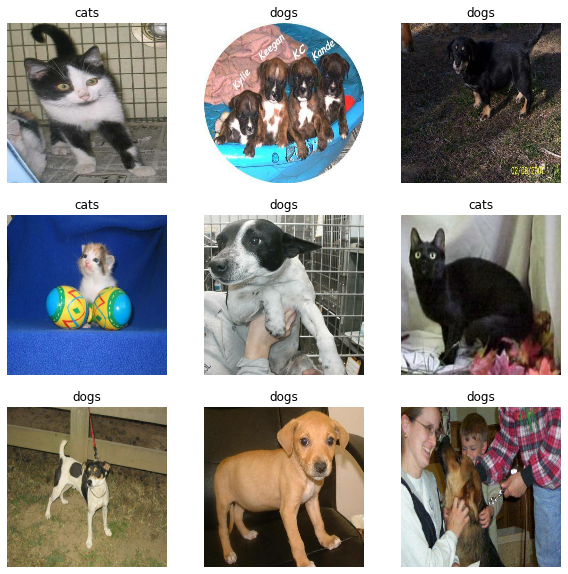

In [27]:
# Show some images from the dataset

test_images = image_dataset_from_directory(validation_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

class_names = test_images.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [28]:
# Configure the dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Data augumentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])



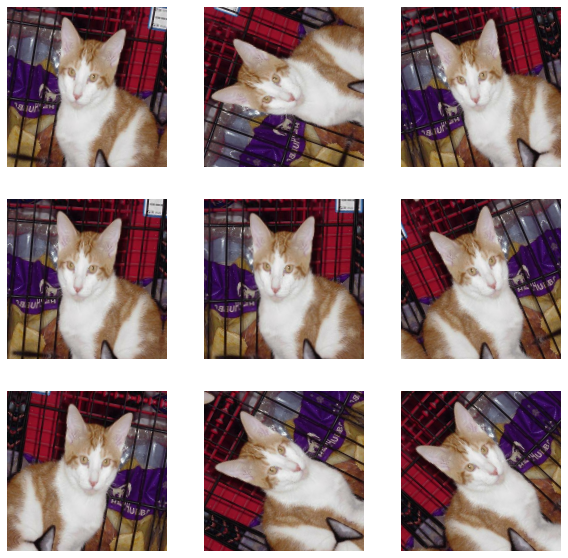

In [29]:
# Testing augmentation
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


In [31]:
# Process datasets to be in the format expected by the MobileNet
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)



In [32]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


9412608/9406464 [==============================] - 0s 0us/step


In [35]:
# Freeze all layers
base_model.trainable = False

#base_model.summary()

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

# Average output to output vector with 1280 values
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch.shape)
print(feature_batch_average.shape)

# Convert all 1280 to one
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

#----------- Create model -------------#
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)



(32, 5, 5, 1280)
(32, 5, 5, 1280)
(32, 1280)
(32, 1)


# DENSE LAYER TRAINING

In [37]:
# Compile model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [38]:
# Training
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)


26/26 [==============================] - 17s 584ms/step - loss: 0.9266 - accuracy: 0.4032


In [39]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)


initial loss: 0.94
initial accuracy: 0.39
Epoch 1/10
63/63 [==============================] - 62s 940ms/step - loss: 0.8095 - accuracy: 0.4830 - val_loss: 0.6229 - val_accuracy: 0.5718
Epoch 2/10
63/63 [==============================] - 59s 933ms/step - loss: 0.6149 - accuracy: 0.6405 - val_loss: 0.4361 - val_accuracy: 0.7426
Epoch 3/10
63/63 [==============================] - 59s 932ms/step - loss: 0.4747 - accuracy: 0.7390 - val_loss: 0.3250 - val_accuracy: 0.8527
Epoch 4/10
63/63 [==============================] - 59s 937ms/step - loss: 0.3883 - accuracy: 0.8045 - val_loss: 0.2617 - val_accuracy: 0.8874
Epoch 5/10
63/63 [==============================] - 60s 955ms/step - loss: 0.3328 - accuracy: 0.8440 - val_loss: 0.2261 - val_accuracy: 0.8948
Epoch 6/10
63/63 [==============================] - 61s 969ms/step - loss: 0.2912 - accuracy: 0.8700 - val_loss: 0.1948 - val_accuracy: 0.9282
Epoch 7/10
63/63 [==============================] - 59s 938ms/step - loss: 0.2657 - accuracy: 0.8775

6/6 [==============================] - 4s 632ms/step - loss: 0.1437 - accuracy: 0.9427


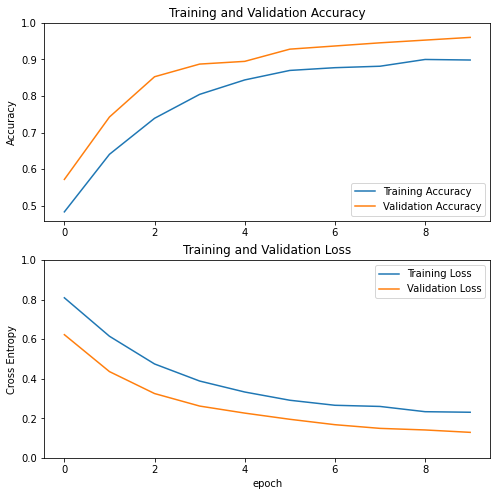

In [42]:
# Training
initial_epochs = 10
loss0, accuracy0 = model.evaluate(test_dataset)

# Analyze model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [44]:
#dense_history = history
#dense_model = model

In [45]:
# Evalueate after trained
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 16s 585ms/step - loss: 0.1283 - accuracy: 0.9629


# FINE-TUNING

In [47]:
# Fine tuning mobile net
base_model.trainable = True# Set mobile net as trainable

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 105

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
            optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
            metrics=['accuracy'])

model.summary()

len(model.trainable_variables)





Number of layers in the base model:  154
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)   

52

In [48]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)


Epoch 10/20
63/63 [==============================] - 88s 1s/step - loss: 0.1992 - accuracy: 0.9103 - val_loss: 0.0634 - val_accuracy: 0.9777
Epoch 11/20
63/63 [==============================] - 81s 1s/step - loss: 0.1182 - accuracy: 0.9519 - val_loss: 0.0559 - val_accuracy: 0.9790
Epoch 12/20
63/63 [==============================] - 82s 1s/step - loss: 0.1085 - accuracy: 0.9489 - val_loss: 0.0511 - val_accuracy: 0.9777
Epoch 13/20
63/63 [==============================] - 82s 1s/step - loss: 0.0874 - accuracy: 0.9695 - val_loss: 0.0441 - val_accuracy: 0.9876
Epoch 14/20
63/63 [==============================] - 82s 1s/step - loss: 0.0894 - accuracy: 0.9635 - val_loss: 0.0429 - val_accuracy: 0.9802
Epoch 15/20
63/63 [==============================] - 82s 1s/step - loss: 0.0871 - accuracy: 0.9645 - val_loss: 0.0450 - val_accuracy: 0.9777
Epoch 16/20
63/63 [==============================] - 81s 1s/step - loss: 0.0778 - accuracy: 0.9644 - val_loss: 0.0514 - val_accuracy: 0.9802
Epoch 17/20
6

In [49]:
# Evalueate after trained
initial_epochs = 10
loss0, accuracy0 = model.evaluate(test_dataset)

6/6 [==============================] - 4s 593ms/step - loss: 0.0399 - accuracy: 0.9792


In [50]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


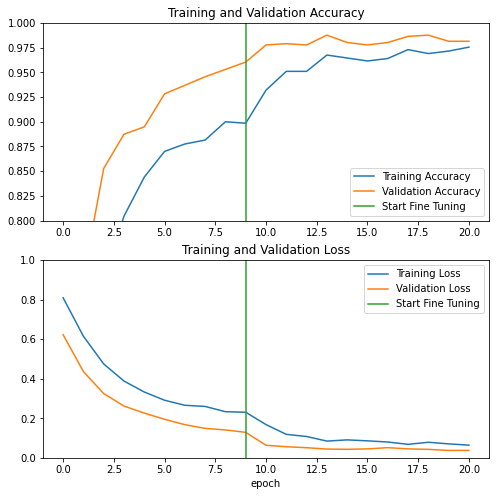

In [51]:

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [60]:
#fine_history = history
#fine_model = model

In [52]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)


6/6 [==============================] - 4s 587ms/step - loss: 0.0318 - accuracy: 0.9896
Test accuracy : 0.9895833134651184


In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")


In [58]:
#model.save("/home")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
open("/home/converted_model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpk8g7ykuc/assets


2647712

In [57]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import tensorflow as tf
from PIL import Image

# predicting images
img = image.load_img('/home/cat.jpeg', target_size=(160, 160))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
predictions = model.predict_on_batch(images).flatten()
print(predictions)

[-11.069564]


In [78]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="/home/converted_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']

img = image.load_img('/home/cat.jpeg', target_size=(160, 160))
x = image.img_to_array(img).reshape(input_shape)
print(x.shape)

#input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
input_data = np.array(x, dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

(1, 160, 160, 3)
[[-11.127892]]


# Remove augmentation

In [71]:
tf.keras.backend.clear_session()

# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
aug_base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
#------------- start Layers
preprocess_input_aug = tf.keras.applications.mobilenet_v2.preprocess_input
rescale_aug = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

image_batch_aug, label_batch_aug = next(iter(train_dataset))
feature_batch_aug = aug_base_model(image_batch_aug)
print(feature_batch.shape)

# Average output to output vector with 1280 values
global_average_layer_aug = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_aug = global_average_layer(feature_batch_aug)
print(feature_batch_aug.shape)
print(feature_batch_average_aug.shape)

# Convert all 1280 to one
prediction_layer_aug = tf.keras.layers.Dense(1)
prediction_batch_aug = prediction_layer_aug(feature_batch_average_aug)
print(prediction_batch_aug.shape)
#------------- end Layers

# Freeze all layers
aug_base_model.trainable = False

#----------- Create model -------------#
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input_aug(inputs)
x = aug_base_model(x, training=False)
x = global_average_layer_aug(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer_aug(x)
aug_model = tf.keras.Model(inputs, outputs)

# Compile model
base_learning_rate = 0.0001
aug_model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
aug_model.summary()

# Training
initial_epochs = 10
loss0, accuracy0 = aug_model.evaluate(test_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))
history = aug_model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)


(32, 5, 5, 1280)
(32, 5, 5, 1280)
(32, 1280)
(32, 1)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (D

In [83]:
# Training
initial_epochs = 10
loss0, accuracy0 = aug_model.evaluate(test_dataset)

6/6 [==============================] - 4s 596ms/step - loss: 0.0977 - accuracy: 0.9740


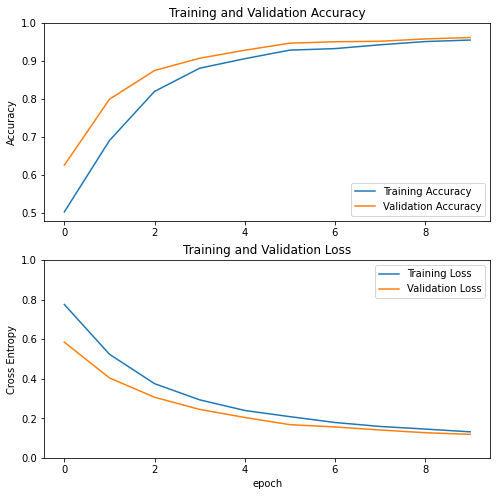

In [79]:
# Analyze model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [82]:
#augmentation_history = history

In [84]:
converter = tf.lite.TFLiteConverter.from_keras_model(aug_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
open("/home/aug_model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpib1kymw4/assets


INFO:tensorflow:Assets written to: /tmp/tmpib1kymw4/assets


2647712

# Increase dropout (0.2->0.5)

In [93]:
tf.keras.backend.clear_session()

# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
drop_base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
#------------- start Layers
preprocess_input_drop = tf.keras.applications.mobilenet_v2.preprocess_input
rescale_drop = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

image_batch_drop, label_batch_drop = next(iter(train_dataset))
feature_batch_drop = drop_base_model(image_batch_drop)
print(feature_batch.shape)

# Data augumentation
data_augmentation_drop = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

# Average output to output vector with 1280 values
global_average_layer_drop = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_drop = global_average_layer(feature_batch_drop)
print(feature_batch_drop.shape)
print(feature_batch_average_drop.shape)

# Convert all 1280 to one
prediction_layer_drop = tf.keras.layers.Dense(1)
prediction_batch_drop = prediction_layer_drop(feature_batch_average_drop)
print(prediction_batch_drop.shape)
#------------- end Layers

# Freeze all layers
drop_base_model.trainable = False

#----------- Create model -------------#
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation_drop(inputs)
x = preprocess_input_drop(x)
x = drop_base_model(x, training=False)
x = global_average_layer_drop(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = prediction_layer_drop(x)
drop_model = tf.keras.Model(inputs, outputs)

# Compile model
base_learning_rate = 0.0001
drop_model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
drop_model.summary()

# Training
initial_epochs = 10
loss0, accuracy0 = drop_model.evaluate(test_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))
history = drop_model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)


KeyboardInterrupt: ignored

In [ ]:
# Training
initial_epochs = 10
loss0, accuracy0 = drop_model.evaluate(test_dataset)

In [ ]:
# Analyze model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#drop_history = history

# Modelo final (fine-tuning augmentation)

In [89]:
# Fine tuning mobile net
aug_base_model.trainable = True# Set mobile net as trainable

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(aug_base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 105

# Freeze all the layers before the `fine_tune_at` layer
for layer in aug_base_model.layers[:fine_tune_at]:
  layer.trainable =  False

aug_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
            optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
            metrics=['accuracy'])

aug_model.summary()

len(aug_model.trainable_variables)


Number of layers in the base model:  154
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)       

52

In [90]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = aug_model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 82s 1s/step - loss: 0.0790 - accuracy: 0.9697 - val_loss: 0.0506 - val_accuracy: 0.9827
Epoch 11/20
63/63 [==============================] - 78s 1s/step - loss: 0.0310 - accuracy: 0.9872 - val_loss: 0.0684 - val_accuracy: 0.9740
Epoch 12/20
63/63 [==============================] - 78s 1s/step - loss: 0.0134 - accuracy: 0.9935 - val_loss: 0.0438 - val_accuracy: 0.9851
Epoch 13/20
63/63 [==============================] - 77s 1s/step - loss: 0.0118 - accuracy: 0.9952 - val_loss: 0.0479 - val_accuracy: 0.9839
Epoch 14/20
63/63 [==============================] - 77s 1s/step - loss: 0.0048 - accuracy: 0.9996 - val_loss: 0.0514 - val_accuracy: 0.9851
Epoch 15/20
63/63 [==============================] - 77s 1s/step - loss: 0.0048 - accuracy: 0.9993 - val_loss: 0.0509 - val_accuracy: 0.9839
Epoch 16/20
63/63 [==============================] - 78s 1s/step - loss: 0.0022 - accuracy: 0.9994 - val_loss: 0.0607 - val_accuracy: 0.9802
Epoch 17/20
6

In [91]:
# Test
initial_epochs = 10
loss0, accuracy0 = aug_model.evaluate(test_dataset)

6/6 [==============================] - 4s 594ms/step - loss: 0.0189 - accuracy: 0.9896


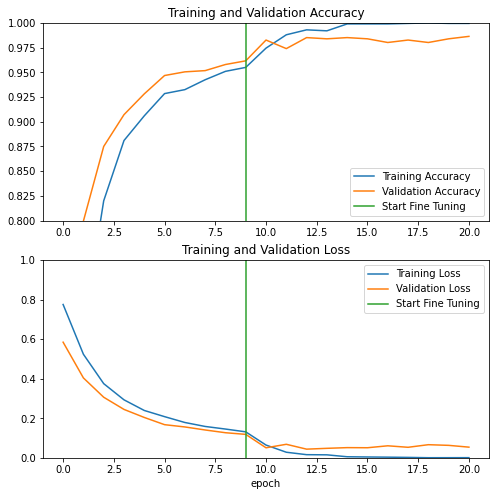

In [92]:
acc = augmentation_history.history['accuracy']
val_acc = augmentation_history.history['val_accuracy']

loss = augmentation_history.history['loss']
val_loss = augmentation_history.history['val_loss']

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [94]:
converter = tf.lite.TFLiteConverter.from_keras_model(aug_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
open("/home/aug_model_fine.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpg8oacgqd/assets


INFO:tensorflow:Assets written to: /tmp/tmpg8oacgqd/assets


2647712